<a href="https://colab.research.google.com/github/sunilrosen/WikiNews-Search-Engine/blob/main/WikiNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch transformers newsapi-python transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import requests
import json
from typing import Optional, List, Tuple
from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.utils import DistanceStrategy
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, Dataset
from newsapi import NewsApiClient
import pacmap
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
import random


pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [ ]:
dataset = load_dataset("wikipedia", "20220301.simple")  # Load Wikipedia Dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
RAW_KNOWLEDGE_BASE = []

# Iterate over the dataset
for item in tqdm(dataset['train']):
    try:
        # Directly access fields in each item
        RAW_KNOWLEDGE_BASE.append(
            Document(
                page_content=item.get("text", ""),
                metadata={
                    "source": item.get("url", "unknown"),
                    "title": item.get("title", "untitled"),
                    "id": item.get("id", "unknown"),
                },
            )
        )
    except Exception as e:
        print(f"Error processing item: {item}\n{e}")

100%|██████████| 205328/205328 [00:12<00:00, 16106.97it/s]


In [ ]:
# Prepare data for JSON serialization
json_data = [
    {
        "page_content": doc.page_content,
        "metadata": doc.metadata,
    }
    for doc in RAW_KNOWLEDGE_BASE
]

# Save to a JSON file
output_file = "/content/drive/My Drive/knowledge_base.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(json_data, f, indent=4, ensure_ascii=False)

print(f"Data successfully saved to {output_file}")

Data successfully saved to knowledge_base.json


In [ ]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').max_seq_length}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 256


In [ ]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

def split_documents(
    chunk_size: int,
    knowledge_base: List[Document],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[Document]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in tqdm(knowledge_base, desc="Splitting documents", unit="doc"):
        docs_processed += text_splitter.split_documents([doc])
    return docs_processed


In [ ]:
docs_processed = split_documents(
    256,  # We chose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

Computing token lengths: 100%|██████████| 377309/377309 [03:24<00:00, 1846.87chunk/s]


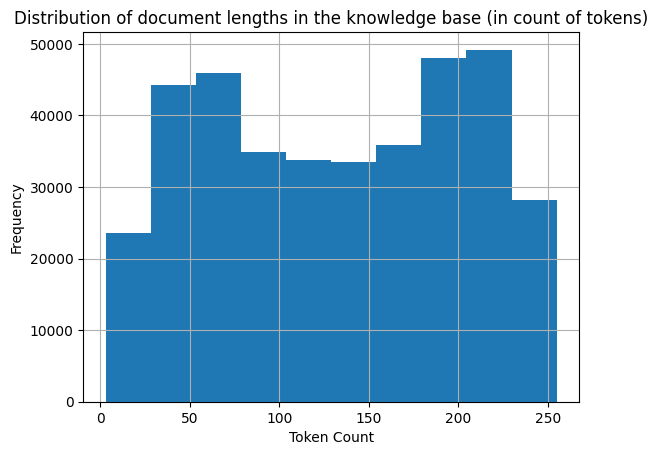

In [ ]:
# Visualize the chunk sizes in tokens
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)

# Add a progress bar to token length computation
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed, desc="Computing token lengths", unit="chunk")]

fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
def save_chunks_to_file(docs_processed: List[Document], output_file: str):
    """
    Save processed chunks to a JSON file for reuse, with a progress bar.
    """
    json_data = []

    for doc in docs_processed, desc="Saving chunks to file", unit="chunk":
        json_data.append({
            "page_content": doc.page_content,
            "metadata": doc.metadata,
        })

    # Save to JSON file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(json_data, f, indent=4, ensure_ascii=False)

save_chunks_to_file(docs_processed, "/content/drive/My Drive/knowledge_base_processed.json")


Saving chunks to file: 100%|██████████| 377309/377309 [00:01<00:00, 271180.03chunk/s]


In [ ]:
def load_chunks_from_file(file_path: str) -> List[Document]:
    """
    Load processed document chunks from a JSON file.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return [Document(page_content=item["page_content"], metadata=item["metadata"]) for item in data]

docs_processed = load_chunks_from_file("/content/drive/My Drive/knowledge_base_processed.json")

In [ ]:
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

<ipython-input-4-1f47f8f0bc24>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Embed NewsApi

In [ ]:
# Initialize NewsAPI client
newsapi = NewsApiClient(api_key="e8241a0e357e4f4797bec7ea4998be07")

def fetch_news_articles(query: str, max_results: int = 10):
    """
    Fetch news articles from NewsAPI.
    """
    response = newsapi.get_everything(
        q=query,
        language="en",
        sort_by="relevancy",
        page_size=max_results,
    )
    articles = response.get("articles", [])
    return [
        {"title": article["title"], "content": article["content"], "url": article["url"]}
        for article in articles if article["content"]
    ]

# Process NewsAPI articles into Document format
def process_news_articles(articles, chunk_size, tokenizer_name):
    """
    Process and chunk news articles into Documents.
    """
    news_docs = [
        Document(page_content=article["content"], metadata={"source": article["url"], "title": article["title"]})
        for article in articles
    ]
    return split_documents(chunk_size, news_docs, tokenizer_name)

# Fetch and process NewsAPI articles
news_articles = fetch_news_articles("Israel-Hezbollah", max_results=20)
print(news_articles)
newsapi_docs_processed = process_news_articles(news_articles, 256, EMBEDDING_MODEL_NAME)


[{'title': 'Israel-Hezbollah ceasefire comes into effect', 'content': 'A view of Beirut, after a ceasefire between Israel and Iran-backed group Hezbollah took effect at 02:00 GMT\r\nA ceasefire following more than a year of fighting between Israel and Hezbollah in Lebanon… [+5384 chars]', 'url': 'https://www.bbc.com/news/articles/c0mze4pzdnlo'}, {'title': 'What we know about Israel-Hezbollah ceasefire deal', 'content': 'Israel launched an air campaign and ground invasion against Hezbollah in late September\r\nUS President Joe Biden has announced a ceasefire deal to end 13 months of fighting between Israel and with Hez… [+4155 chars]', 'url': 'https://www.bbc.com/news/articles/cx2d3gj9ewxo'}, {'title': 'Israeli and Hezbollah strikes test limits of ceasefire', 'content': 'Lebanese people have been returning to their homes following the ceasefire agreement \r\nThe latest exchange of fire between Israel and Hezbollah is testing the limits of last weeks already fragile cea… [+4960 chars]', 

Splitting documents: 100%|██████████| 20/20 [00:00<00:00, 384.58doc/s]


In [ ]:
# Combine Wikipedia and NewsAPI processed chunks
combined_docs = docs_processed + newsapi_docs_processed

# Embed and store in a combined FAISS vector store
COMBINED_VECTOR_DATABASE = FAISS.from_documents(
    combined_docs, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
# Save FAISS index to disk
COMBINED_VECTOR_DATABASE.save_local("faiss_index")
print("FAISS index saved to disk.")

FAISS index saved to disk.


In [ ]:
# Load the FAISS index from disk
COMBINED_VECTOR_DATABASE = FAISS.load_local("faiss_index", embedding_model, allow_dangerous_deserialization=True)
print("FAISS index loaded from disk.")

FAISS index loaded from disk.


In [ ]:
# Embed a user query in the same space
user_query = "What day was the Israel-Hezbollah Cease Fire?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
# Extract embeddings from FAISS
embeddings = COMBINED_VECTOR_DATABASE.index.reconstruct_batch(np.arange(len(docs_processed)))
embeddings_2d = list(embeddings) + [query_vector]

# Downsample large datasets (e.g., retain only 1000 random points)
sample_size = 1000  # Adjust as needed
if len(embeddings_2d) > sample_size:
    sample_indices = random.sample(range(len(embeddings)), k=sample_size)
    downsampled_embeddings = [embeddings_2d[i] for i in sample_indices]
    downsampled_docs = [docs_processed[i] for i in sample_indices]
    # Add the query back after downsampling
    downsampled_embeddings.append(query_vector)
    downsampled_docs.append({"metadata": {"source": "User query"}, "page_content": user_query})
else:
    downsampled_embeddings = embeddings_2d
    downsampled_docs = docs_processed + [{"metadata": {"source": "User query"}, "page_content": user_query}]

# Reduce dimensionality with PCA
pca = PCA(n_components=50, random_state=1)
reduced_embeddings = pca.fit_transform(np.array(downsampled_embeddings))

# Apply PaCMAP for 2D projection
embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0, random_state=1)
documents_projected = embedding_projector.fit_transform(reduced_embeddings, init="pca")

# Build a DataFrame for visualization
data = [
    {
        "x": documents_projected[i, 0],
        "y": documents_projected[i, 1],
        "source": downsampled_docs[i].metadata["source"].split("/")[1]
        if "source" in downsampled_docs[i].metadata else "Unknown",
        "extract": downsampled_docs[i].page_content[:100] + "...",
        "symbol": "circle",
        "size_col": 4,
    }
    for i in range(len(downsampled_docs) - 1)
]
data.append(
    {
        "x": documents_projected[-1, 0],
        "y": documents_projected[-1, 1],
        "source": "User query",
        "extract": user_query,
        "size_col": 100,
        "symbol": "star",
    }
)
df = pd.DataFrame(data)

# Visualize the embeddings with Plotly
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data=["extract"],
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=0.8, line=dict(width=0)),  # Optimize marker rendering
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
    dragmode=False,  # Disable dragging for performance
)
fig.show()


In [ ]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = COMBINED_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='What day was the Israel-Hezbollah Cease Fire?'...

==================================Top document==================================
A cease-fire took effect on the morning of November 27, 2024.JALAA MAREY/AFP via Getty Images
<ul><li>A cease-fire deal aims to end the Israel-Hezbollah conflict after nearly 14 months of fighting.<… [+4210 chars]
==================================Metadata==================================
{'source': 'https://www.businessinsider.com/israel-hezbollah-cease-fire-deal-hope-but-us-role-complicated-2024-11', 'title': "The Israel-Hezbollah cease-fire deal brings hope, but the US' role of monitoring violations raises issues", 'start_index': 0}


In [ ]:
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
# Template to generate context-based answers
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [ ]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="What day was the Israel-Hezbollah Cease Fire?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The Israel-Hezbollah ceasefire took effect on November 27, 2024 (Document 0). However, this does not appear to be accurate based on the context provided. In Documents 3 and 4, there are references to previous conflicts between Israel and Hezbollah, including the 2006 Lebanon War, which suggests that the ceasefire mentioned in Document 0 may be referring to a different conflict. Without further information or context, it is unclear which ceasefire is being referred to in Document 0. Therefore, I would recommend verifying the accuracy of this information before using it in your response. If the accuracy of this information cannot be confirmed, it would be best to not include it in your answer.


In [ ]:
from transformers import Pipeline
from typing import Tuple, List

def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    num_retrieved_docs: int = 8,
    num_docs_final: int = 3,
) -> Tuple[str, List[dict]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)

    # Keep text and metadata
    relevant_docs = [
        {"text": doc.page_content, "source": doc.metadata.get("source", "Unknown source")}
        for doc in relevant_docs
    ]

    # Limit the number of documents to the final number
    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt with source information
    context = "\nExtracted documents:\n"
    context += "".join(
        [
            f"Document from {doc['source']}:\n{doc['text']}\n"
            for doc in relevant_docs
        ]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Generate the answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [ ]:
question = "What day was the Israel-Hezbollah Cease Fire?"

answer, relevant_docs = answer_with_rag(question, READER_LLM, COMBINED_VECTOR_DATABASE)

=> Retrieving documents...
=> Generating answer...


In [ ]:
print("==================================Answer==================================")
print(f"{answer}")

==================================Answer==================================
The Israel-Hezbollah Cease Fire took effect on November 27, 2024, as mentioned in the first extracted document from Business Insider. The second extracted document from BBC also confirms this date. Therefore, the answer is November 27, 2024.


In [ ]:
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Source docs==================================
Document 0------------------------------------------------------------
{'text': 'A cease-fire took effect on the morning of November 27, 2024.JALAA MAREY/AFP via Getty Images\r\n<ul><li>A cease-fire deal aims to end the Israel-Hezbollah conflict after nearly 14 months of fighting.<… [+4210 chars]', 'source': 'https://www.businessinsider.com/israel-hezbollah-cease-fire-deal-hope-but-us-role-complicated-2024-11'}
Document 1------------------------------------------------------------
{'text': 'A view of Beirut, after a ceasefire between Israel and Iran-backed group Hezbollah took effect at 02:00 GMT\r\nA ceasefire following more than a year of fighting between Israel and Hezbollah in Lebanon… [+5384 chars]', 'source': 'https://www.bbc.com/news/articles/c0mze4pzdnlo'}
Document 2------------------------------------------------------------
{'text': 'Hezbollah is supported by Syria, Iran, Russia, Lebanon and Iraq.